## 0. Importare biblioteci necesare

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
print("Done")

Done


## 1. Inițializare model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 2. Încărcare și preprocesare set de date MNIST

In [3]:
#preprocessing the images for CNN
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) 


#transform to tensor and also normalize the values [-1,1]
#normalized-value = (original_value - miu)/std

#downloading the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#loading DataLoader (trainer for data loading in Python)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = False)
print("Done")

Done


## 3. Definirea rețelei neuronale

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Dimensiune: (batch_size, 32, 28, 28)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Dimensiune: (batch_size, 64, 28, 28)
        self.pool = nn.MaxPool2d(2, 2)  # Dimensiune după pooling: (batch_size, 64, 14, 14)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  # Dimensiune de intrare corectă pentru fc1
        self.fc2 = nn.Linear(128, 10)  # Ieșire: 10 clase
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))  # Aplică primul strat de convoluție și ReLU
        x = self.pool(self.relu(self.conv2(x)))  # Aplică al doilea strat de convoluție și pooling
        x = x.view(x.size(0), -1)  # Aplatizează tensorul pentru a-l introduce în stratul complet conectat
        x = self.relu(self.fc1(x))  # Aplică primul strat complet conectat
        x = self.fc2(x)  # Aplică stratul final complet conectat
        return x

model = CNN()

## 4. Configurare funcție de pierdere și optimizator

In [5]:
criterion = nn.CrossEntropyLoss()  # Funcția de pierdere pentru clasificare
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizatorul Adam

print("Done")

Done


## 5. Antrenarea rețelei

In [6]:
epochs = 10
for epoch in range(epochs):
    model.train()
    current_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss.item()

    avg_loss = current_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.1147
Epoch [2/10], Loss: 0.0369
Epoch [3/10], Loss: 0.0238
Epoch [4/10], Loss: 0.0163
Epoch [5/10], Loss: 0.0108
Epoch [6/10], Loss: 0.0099
Epoch [7/10], Loss: 0.0066
Epoch [8/10], Loss: 0.0072
Epoch [9/10], Loss: 0.0050
Epoch [10/10], Loss: 0.0076


## 6. Evaluare model

In [7]:
correct = 0
total = 0

model.eval() 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 98.99%


## 7. Vizualizare pierdere și acuratețe

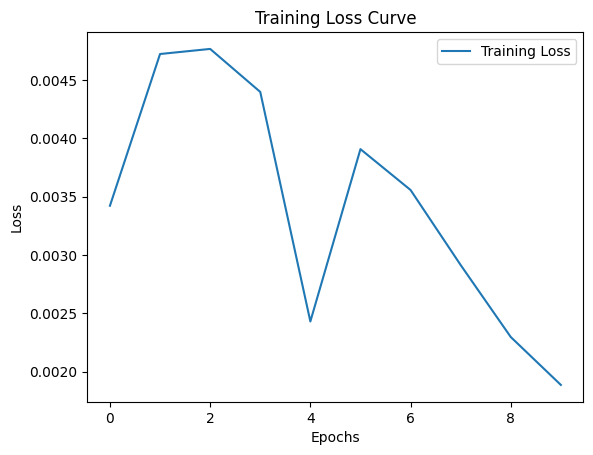

In [13]:
plt.plot(losses, label="Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

## 8. Salvare model

In [9]:
dummy_input = torch.randn(1, 1, 28, 28).to(device) 
onnx_file_path = "trained_model.onnx"

model.eval()
torch.onnx.export(model, dummy_input, onnx_file_path, export_params=True, opset_version=11,
                  input_names=['input'], output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})

print(f"Model saved to {onnx_file_path}")


Model saved to trained_model.onnx
